<a href="https://colab.research.google.com/github/Ogutierreze/First_Probabiliy_example/blob/main/Primer_Parcial_TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Dashboard**

In [34]:
!pip install streamlit pyngrok --quiet


In [40]:
!ngrok config add-authtoken 2xWcKWlPgoOi7LvXKYLFdtI6LMj_4LVnLhWZamwtN2n5b7eyD


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [96]:
codigo = '''
# dashboard_colab.py
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(layout='wide')

# === Funciones de preprocesamiento ===
def cargar_datos(ruta):
    df = pd.read_csv(ruta)
    st.write(f"📊 Dimensiones iniciales del DataFrame: {df.shape}")
    return df

def eliminar_columnas_con_muchos_nulos(df, umbral=0.7):
    porcentaje_no_nulos = df.notnull().mean()
    columnas_a_conservar = porcentaje_no_nulos[porcentaje_no_nulos >= umbral].index.tolist()
    columnas_a_eliminar = porcentaje_no_nulos[porcentaje_no_nulos < umbral].index.tolist()
    df_filtrado = df[columnas_a_conservar]
    st.write(f"🗑️ Columnas eliminadas: {len(columnas_a_eliminar)}")
    return df_filtrado

def eliminar_filas_con_muchos_nulos(df, max_nulos=15):
    df_filtrado = df[df.isnull().sum(axis=1) <= max_nulos].reset_index(drop=True)
    st.write(f"✅ Filas después de eliminar por nulos: {df_filtrado.shape[0]}")
    return df_filtrado

def eliminar_variables_numericas_poca_correlacion(df, variable_objetivo='SalePrice', umbral=0.04):
    columnas_categoricas_obj = df.select_dtypes(include=['object', 'category']).columns.tolist()
    columnas_numericas_categoricas = [col for col in ['MS SubClass', 'Mo Sold', 'Yr Sold'] if col in df.columns]
    columnas_cualitativas = list(set(columnas_categoricas_obj + columnas_numericas_categoricas))
    columnas_numericas_reales = [col for col in df.select_dtypes(include=['number']).columns if col not in columnas_numericas_categoricas]
    correlaciones = df[columnas_numericas_reales].corr()[variable_objetivo].abs()
    columnas_conservar = correlaciones[correlaciones >= umbral].index.tolist()
    columnas_a_conservar = list(set(columnas_conservar + columnas_cualitativas))
    df_filtrado = df[columnas_a_conservar].copy()
    st.write(f"📐 Columnas conservadas por correlación >= {umbral}: {len(columnas_conservar)}")
    return df_filtrado

def imputar_datos(df):
    df_imputado = df.copy()
    columnas_con_nulos = df.columns[df.isnull().any()].tolist()
    columnas_numericas = df.select_dtypes(include=['number']).columns.tolist()
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in [c for c in columnas_numericas if c in columnas_con_nulos]:
        if abs(df[col].skew()) > 1:
            df_imputado[col] = df[col].fillna(df[col].median())
        else:
            df_imputado[col] = df[col].fillna(df[col].mean())
    for col in [c for c in columnas_categoricas if c in columnas_con_nulos]:
        moda = df[col].mode(dropna=True)
        if not moda.empty:
            df_imputado[col] = df[col].fillna(moda[0])
    return df_imputado

def mostrar_matriz_correlacion_numerica(df):
    df_num = df.select_dtypes(include=['number'])
    corr = df_num.corr()
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", square=True, ax=ax)
    ax.set_title("🔗 Matriz de Correlación entre Variables Numéricas", fontsize=16)
    st.pyplot(fig)

def mostrar_matriz_dispersion(df):
    variables = ['SalePrice', 'Gr Liv Area', 'Overall Qual', 'Garage Area', 'Mo Sold']
    columnas_presentes = [var for var in variables if var in df.columns]
    if len(columnas_presentes) >= 2:
        fig = sns.pairplot(df[columnas_presentes], diag_kind='kde', plot_kws={'alpha': 0.6})
        st.pyplot(fig)
    else:
        st.warning("⚠️ No hay suficientes variables seleccionadas para crear la matriz de dispersión.")

# === Streamlit App ===
st.title("🔍 Dashboard de Preprocesamiento y Modelado")

ruta = st.text_input("📁 Ruta al archivo CSV:", value="/content/drive/MyDrive/Audios_Señal/AmesHousing.csv")
if st.button("📥 Cargar y Preprocesar Datos"):
    df = cargar_datos(ruta)
    df = eliminar_columnas_con_muchos_nulos(df)
    df = eliminar_filas_con_muchos_nulos(df)
    df = eliminar_variables_numericas_poca_correlacion(df)
    df = imputar_datos(df)

    if 'PID' in df.columns:
        df = df.drop(columns=['PID'])

    st.subheader("📋 Vista previa del DataFrame")
    st.dataframe(df.head(20))

    st.subheader("📊 Matriz de Correlación")
    mostrar_matriz_correlacion_numerica(df)

    st.subheader("📈 Matriz de Dispersión Seleccionada")
    mostrar_matriz_dispersion(df)

    # === Sección de visualización de resultados de modelos ===
    st.subheader("🖼️ Visualización de Resultados de Modelos")

    st.markdown("**📌 Imagen 1: Tabla de métricas de desempeño (KernelRidge y Random Forest)**")
    url_img1 = st.text_input("🔗 Enlace público de Google Drive para la Imagen 1 (tabla)",
        value="https://drive.google.com/uc?export=view&id=1-FdoBHMCoKgrYplPIhxYa5LmFvYU1D-M")
    st.image(url_img1, caption="Métricas de Desempeño", use_container_width=True)

    st.markdown("**📌 Imagen 2: Gráfica de MAE (Top 3 modelos)**")
    url_img2 = st.text_input("🔗 Enlace público de Google Drive para la Imagen 2 (gráfica)",
        value="https://drive.google.com/uc?export=view&id=1_FPu0VmVA_OGTsX4yuFvE4stbHe5vg_C")
    st.image(url_img2, caption="Gráfica de MAE", use_container_width=True)

    st.markdown("**📌 Imagen 3: Gráfica Predicción vs Valor Real**")
    url_img3 = st.text_input("🔗 Enlace público de Google Drive para la Imagen 3 (predicción vs real)",
        value="https://drive.google.com/uc?export=view&id=19FJE-A5LAtegBziFgDdl1XgqW4B0CVFB")
    st.image(url_img3, caption="Predicción vs Valor Real", use_container_width=True)
'''

with open("dashboard_colab.py", "w") as f:
    f.write(codigo)


In [97]:
from pyngrok import ngrok
ngrok.kill()  # Cierra todos los túneles abiertos en esta sesión


In [98]:
from pyngrok import ngrok
import threading
import time
import os

# Usar configuración moderna compatible con ngrok v3
public_url = ngrok.connect(addr="8501", proto="http")
print(f"🌐 Accede a tu dashboard aquí: {public_url}")

# Ejecutar Streamlit
def run():
    os.system("streamlit run dashboard_colab.py")

thread = threading.Thread(target=run)
thread.start()
time.sleep(5)


🌐 Accede a tu dashboard aquí: NgrokTunnel: "https://542c-35-187-149-64.ngrok-free.app" -> "http://localhost:8501"


## 📂 Carga y limpieza inicial del conjunto de datos Ames Housing

Esta celda define funciones para realizar el preprocesamiento inicial del dataset:
- `cargar_datos`: carga el archivo CSV desde la ruta especificada.
- `eliminar_columnas_con_muchos_nulos`: elimina columnas con más de un 30% de valores nulos (ajustable con `umbral`).
- `eliminar_filas_con_muchos_nulos`: elimina filas con más de 15 valores nulos (ajustable con `max_nulos`).
- `preprocesar_datos`: ejecuta en secuencia todo el preprocesamiento sobre el CSV de Ames Housing.

📌 Este paso asegura que el análisis posterior se realice sobre un conjunto de datos limpio y confiable.


In [45]:
import pandas as pd

def cargar_datos(ruta):
    df = pd.read_csv(ruta)
    print(f"📊 Dimensiones iniciales del DataFrame: {df.shape}")
    return df

def eliminar_columnas_con_muchos_nulos(df, umbral=0.7):
    porcentaje_no_nulos = df.notnull().mean()
    columnas_a_conservar = porcentaje_no_nulos[porcentaje_no_nulos >= umbral].index.tolist()
    columnas_a_eliminar = porcentaje_no_nulos[porcentaje_no_nulos < umbral].index.tolist()

    df_filtrado = df[columnas_a_conservar]

    print(f"🔍 Columnas eliminadas por tener más del {int((1 - umbral)*100)}% de valores nulos: {len(columnas_a_eliminar)}")
    if columnas_a_eliminar:
        print("🗑️ Nombres de las columnas eliminadas:")
        for col in columnas_a_eliminar:
            print(f" - {col}")

    return df_filtrado, columnas_a_eliminar

def eliminar_filas_con_muchos_nulos(df, max_nulos=15):
    filas_iniciales = df.shape[0]
    df_filtrado = df[df.isnull().sum(axis=1) <= max_nulos].reset_index(drop=True)
    filas_eliminadas = filas_iniciales - df_filtrado.shape[0]

    print(f"🗑️ Filas eliminadas por tener más de {max_nulos} valores nulos: {filas_eliminadas}")
    print(f"✅ Filas restantes en el DataFrame: {df_filtrado.shape[0]}")
    return df_filtrado

def preprocesar_datos(ruta_csv, umbral_columnas=0.7, max_nulos_fila=15):
    df = cargar_datos(ruta_csv)
    df, _ = eliminar_columnas_con_muchos_nulos(df, umbral=umbral_columnas)
    df = eliminar_filas_con_muchos_nulos(df, max_nulos=max_nulos_fila)
    return df

# ==== Ejecución ====
ruta = '/content/drive/MyDrive/Audios_Señal/AmesHousing.csv'
df = preprocesar_datos(ruta)


📊 Dimensiones iniciales del DataFrame: (2930, 82)
🔍 Columnas eliminadas por tener más del 30% de valores nulos: 6
🗑️ Nombres de las columnas eliminadas:
 - Alley
 - Mas Vnr Type
 - Fireplace Qu
 - Pool QC
 - Fence
 - Misc Feature
🗑️ Filas eliminadas por tener más de 15 valores nulos: 0
✅ Filas restantes en el DataFrame: 2930


## 🧮 Selección de variables numéricas con correlación relevante

Esta celda elimina variables numéricas que tienen baja correlación con la variable objetivo `SalePrice`.  
El proceso:
- Conserva todas las variables categóricas, incluso si están codificadas como números (`MS SubClass`, `Mo Sold`, `Yr Sold`).
- Calcula la correlación absoluta entre cada variable numérica y la variable objetivo.
- Elimina las columnas numéricas cuya correlación sea menor al umbral definido (por defecto `0.04`).

📌 Este paso reduce la dimensionalidad del conjunto de datos y mantiene solo las variables numéricas más informativas para la predicción.


In [46]:
def eliminar_variables_numericas_poca_correlacion(df, variable_objetivo='SalePrice', umbral=0.04):
    """
    Elimina columnas numéricas con baja correlación respecto a la variable objetivo.
    Conserva automáticamente todas las columnas categóricas, incluyendo algunas codificadas como números.

    Retorna:
    - df_filtrado: DataFrame con columnas relevantes
    - columnas_eliminadas: columnas numéricas descartadas
    """

    # === 1. Detectar columnas claramente categóricas (object, category)
    columnas_categoricas_obj = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # === 2. Definir columnas numéricas que deberían tratarse como categóricas
    columnas_numericas_categoricas = [
        'MS SubClass', 'Mo Sold', 'Yr Sold'
    ]
    columnas_numericas_categoricas = [col for col in columnas_numericas_categoricas if col in df.columns]

    # === 3. Construir lista final de columnas cualitativas a conservar
    columnas_cualitativas = list(set(columnas_categoricas_obj + columnas_numericas_categoricas))

    # === 4. Separar numéricas excluyendo las categóricas reconocidas
    columnas_numericas_reales = [col for col in df.select_dtypes(include=['number']).columns if col not in columnas_numericas_categoricas]

    # === 5. Validar existencia de variable objetivo
    if variable_objetivo not in columnas_numericas_reales:
        raise ValueError(f"La columna '{variable_objetivo}' no está en las columnas numéricas reales.")

    # === 6. Calcular correlaciones
    correlaciones = df[columnas_numericas_reales].corr()[variable_objetivo].abs()
    columnas_conservar = correlaciones[correlaciones >= umbral].index.tolist()
    columnas_eliminadas = [col for col in columnas_numericas_reales if col not in columnas_conservar]

    # === 7. Conservar todas las categóricas + numéricas relevantes
    columnas_a_conservar = columnas_conservar + columnas_cualitativas
    columnas_a_conservar = list(set(columnas_a_conservar))  # evitar duplicados

    df_filtrado = df[columnas_a_conservar].copy()

    # === 8. Reporte
    print(f"📈 Umbral de correlación mínima: {umbral}")
    print(f"🔢 Columnas numéricas evaluadas: {len(columnas_numericas_reales)}")
    print(f"✅ Columnas numéricas conservadas: {len(columnas_conservar)}")
    print(f"🗑️ Columnas numéricas eliminadas: {len(columnas_eliminadas)}")
    print(f"📐 Dimensiones finales del DataFrame: {df_filtrado.shape}")

    return df_filtrado, columnas_eliminadas


df, columnas_eliminadas = eliminar_variables_numericas_poca_correlacion(df)



📈 Umbral de correlación mínima: 0.04
🔢 Columnas numéricas evaluadas: 36
✅ Columnas numéricas conservadas: 30
🗑️ Columnas numéricas eliminadas: 6
📐 Dimensiones finales del DataFrame: (2930, 70)


## 🧼 Imputación de valores nulos según tipo y distribución

Esta celda define una función para imputar valores faltantes (`NaN`) en el conjunto de datos `df`:

- 🔢 **Variables numéricas**:
  - Se calcula la asimetría (`skew`) de cada columna.
  - Si la asimetría es baja (|skew| ≤ 1), se imputa con la **media**.
  - Si es alta (|skew| > 1), se imputa con la **mediana**.
- 🔠 **Variables categóricas**:
  - Se imputan con la **moda** (valor más frecuente).

📌 Esta estrategia de imputación es robusta y adaptativa a la distribución de los datos. Es crucial para evitar sesgos en modelos de regresión posteriores.


In [47]:
import pandas as pd
import numpy as np

def imputar_datos(df):
    """
    Imputa valores nulos en un DataFrame.
    - Columnas numéricas: con media o mediana según asimetría.
    - Columnas categóricas: con moda.
    Retorna el DataFrame imputado y un resumen.
    """
    df_imputado = df.copy()

    # === 1. Identificar columnas con valores nulos
    columnas_con_nulos = df.columns[df.isnull().any()].tolist()
    print(f"🧪 Columnas con valores nulos: {len(columnas_con_nulos)}")

    # === 2. Separar por tipo de dato
    columnas_numericas = df.select_dtypes(include=['number']).columns.tolist()
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()

    columnas_con_nulos_numericas = [col for col in columnas_numericas if col in columnas_con_nulos]
    columnas_con_nulos_categoricas = [col for col in columnas_categoricas if col in columnas_con_nulos]

    imputadas_media = []
    imputadas_mediana = []
    imputadas_moda = []

    # === 3. Imputar variables numéricas
    for col in columnas_con_nulos_numericas:
        # Calcular asimetría (skewness)
        skew = df[col].skew()
        if abs(skew) > 1:
            valor = df[col].median()
            imputadas_mediana.append(col)
        else:
            valor = df[col].mean()
            imputadas_media.append(col)
        df_imputado[col] = df[col].fillna(valor)

    # === 4. Imputar variables categóricas con moda
    for col in columnas_con_nulos_categoricas:
        moda = df[col].mode(dropna=True)
        if not moda.empty:
            df_imputado[col] = df[col].fillna(moda[0])
            imputadas_moda.append(col)

    # === 5. Reporte final
    print(f"📊 Variables numéricas imputadas con MEDIA: {len(imputadas_media)}")
    print(f"📈 Variables numéricas imputadas con MEDIANA: {len(imputadas_mediana)}")
    print(f"🔤 Variables categóricas imputadas con MODA: {len(imputadas_moda)}")

    return df_imputado


df = imputar_datos(df)


🧪 Columnas con valores nulos: 19
📊 Variables numéricas imputadas con MEDIA: 5
📈 Variables numéricas imputadas con MEDIANA: 4
🔤 Variables categóricas imputadas con MODA: 10


In [48]:
columnas_numericas = df.select_dtypes(include=['number']).columns
print(columnas_numericas)


Index(['Enclosed Porch', 'Year Built', 'Bsmt Full Bath', 'Full Bath',
       'Mas Vnr Area', 'Pool Area', 'Fireplaces', 'MS SubClass',
       'Overall Qual', 'PID', 'Gr Liv Area', '1st Flr SF', 'Screen Porch',
       'BsmtFin SF 1', 'SalePrice', 'Total Bsmt SF', '2nd Flr SF',
       'TotRms AbvGrd', 'Wood Deck SF', 'Kitchen AbvGr', 'Garage Cars',
       'Year Remod/Add', 'Overall Cond', 'Bsmt Unf SF', 'Lot Frontage',
       'Mo Sold', 'Yr Sold', 'Bedroom AbvGr', 'Garage Area', 'Open Porch SF',
       'Lot Area', 'Half Bath', 'Garage Yr Blt'],
      dtype='object')


## 🧾 Exploración interactiva del DataFrame preprocesado

Esta celda permite **explorar dinámicamente** el conjunto de datos `df` tras el preprocesamiento:

- Se elimina la columna `PID`, ya que es solo un identificador y no aporta valor al modelado.
- Se implementa una interfaz con `ipywidgets` que permite **desplazarse por bloques de 20 filas** usando un control deslizante (`slider`).
- Los datos se muestran en una tabla HTML con desplazamiento horizontal para una mejor visualización.

📌 Esta herramienta es útil para inspeccionar visualmente los valores después del proceso de limpieza e imputación.



In [49]:
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets

df = df.drop(columns=['PID'])  # Eliminar PID antes del modelado

def mostrar_filas_scroll(inicio=0):
    fin = inicio + 20
    subset = df.iloc[inicio:fin]

    html = subset.to_html(max_rows=20)
    scroll_html = f'''
    <div style="overflow-x: auto; white-space: nowrap">
        {html}
    </div>
    '''
    display(HTML(scroll_html))

widgets.interact(mostrar_filas_scroll, inicio=widgets.IntSlider(min=0, max=max(len(df)-20, 1), step=1, value=0))


interactive(children=(IntSlider(value=0, description='inicio', max=2910), Output()), _dom_classes=('widget-int…

<function __main__.mostrar_filas_scroll(inicio=0)>

## 📉 Matriz de dispersión entre variables clave

Esta celda genera una **matriz de dispersión** (`pairplot`) para visualizar relaciones bivariadas entre variables seleccionadas del dataset Ames Housing:

- `SalePrice` (variable objetivo)
- `Gr Liv Area` (área habitable sobre nivel)
- `Overall Qual` (calidad general de la vivienda)
- `Garage Area` (área del garaje)
- `Mo Sold` (mes de venta)

🔹 Se usa `diag_kind='kde'` para mostrar la densidad univariada en la diagonal.  
🔹 La opacidad (`alpha=0.6`) ayuda a identificar la concentración de puntos.

📌 Esta visualización es útil para detectar relaciones lineales o no lineales, así como posibles outliers o agrupamientos.


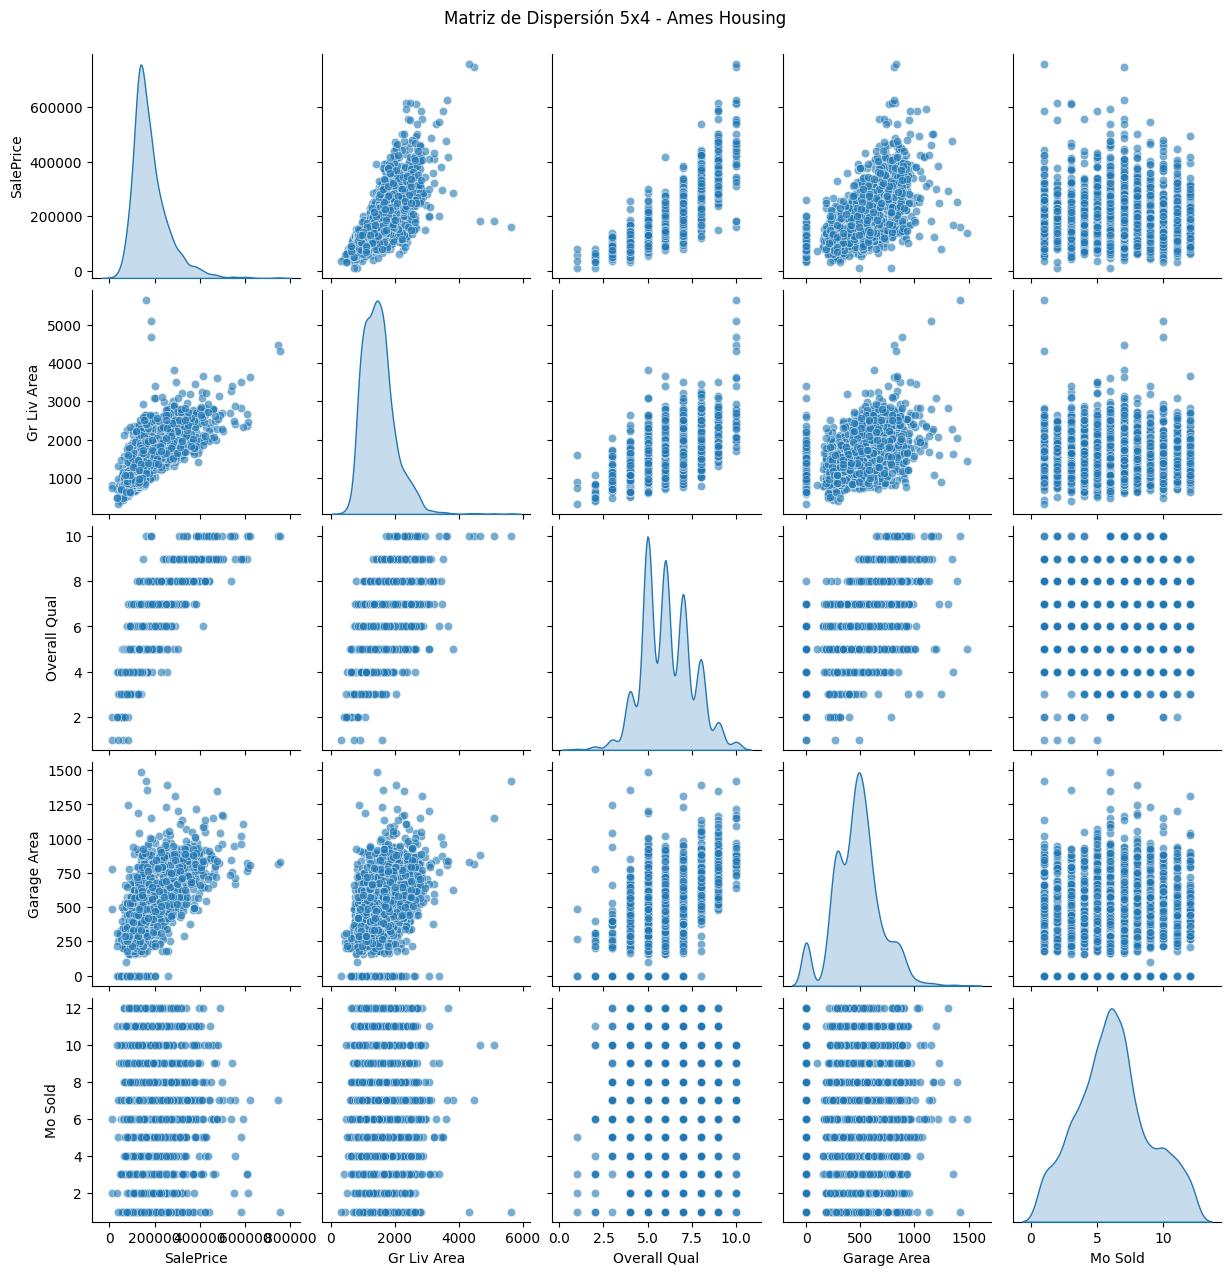

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables seleccionadas
variables = ['SalePrice', 'Gr Liv Area', 'Overall Qual', 'Garage Area', 'Mo Sold']

# Crear la matriz de dispersión
sns.pairplot(df[variables], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Matriz de Dispersión 5x4 - Ames Housing', y=1.02)
plt.show()


## 🔗 Matriz de correlación entre variables numéricas

Esta celda define una función que calcula y visualiza la **matriz de correlación** entre todas las variables numéricas del DataFrame `df`, utilizando un mapa de calor (`heatmap`):

- Se seleccionan automáticamente solo las columnas de tipo numérico.
- La matriz muestra cómo se correlacionan las variables entre sí (coeficiente de Pearson).
- Se utiliza la paleta de colores `coolwarm` para distinguir visualmente correlaciones positivas y negativas.
- El parámetro `anotar` permite opcionalmente mostrar los valores numéricos de correlación dentro de cada celda.

📌 Esta visualización es clave para identificar variables redundantes o fuertemente relacionadas con la variable objetivo (`SalePrice`), lo cual es útil para selección de características y reducción de dimensionalidad.


📐 Variables numéricas: 32
🧮 Calculando matriz de correlación...


<ipython-input-21-70922b8be34e>:24: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


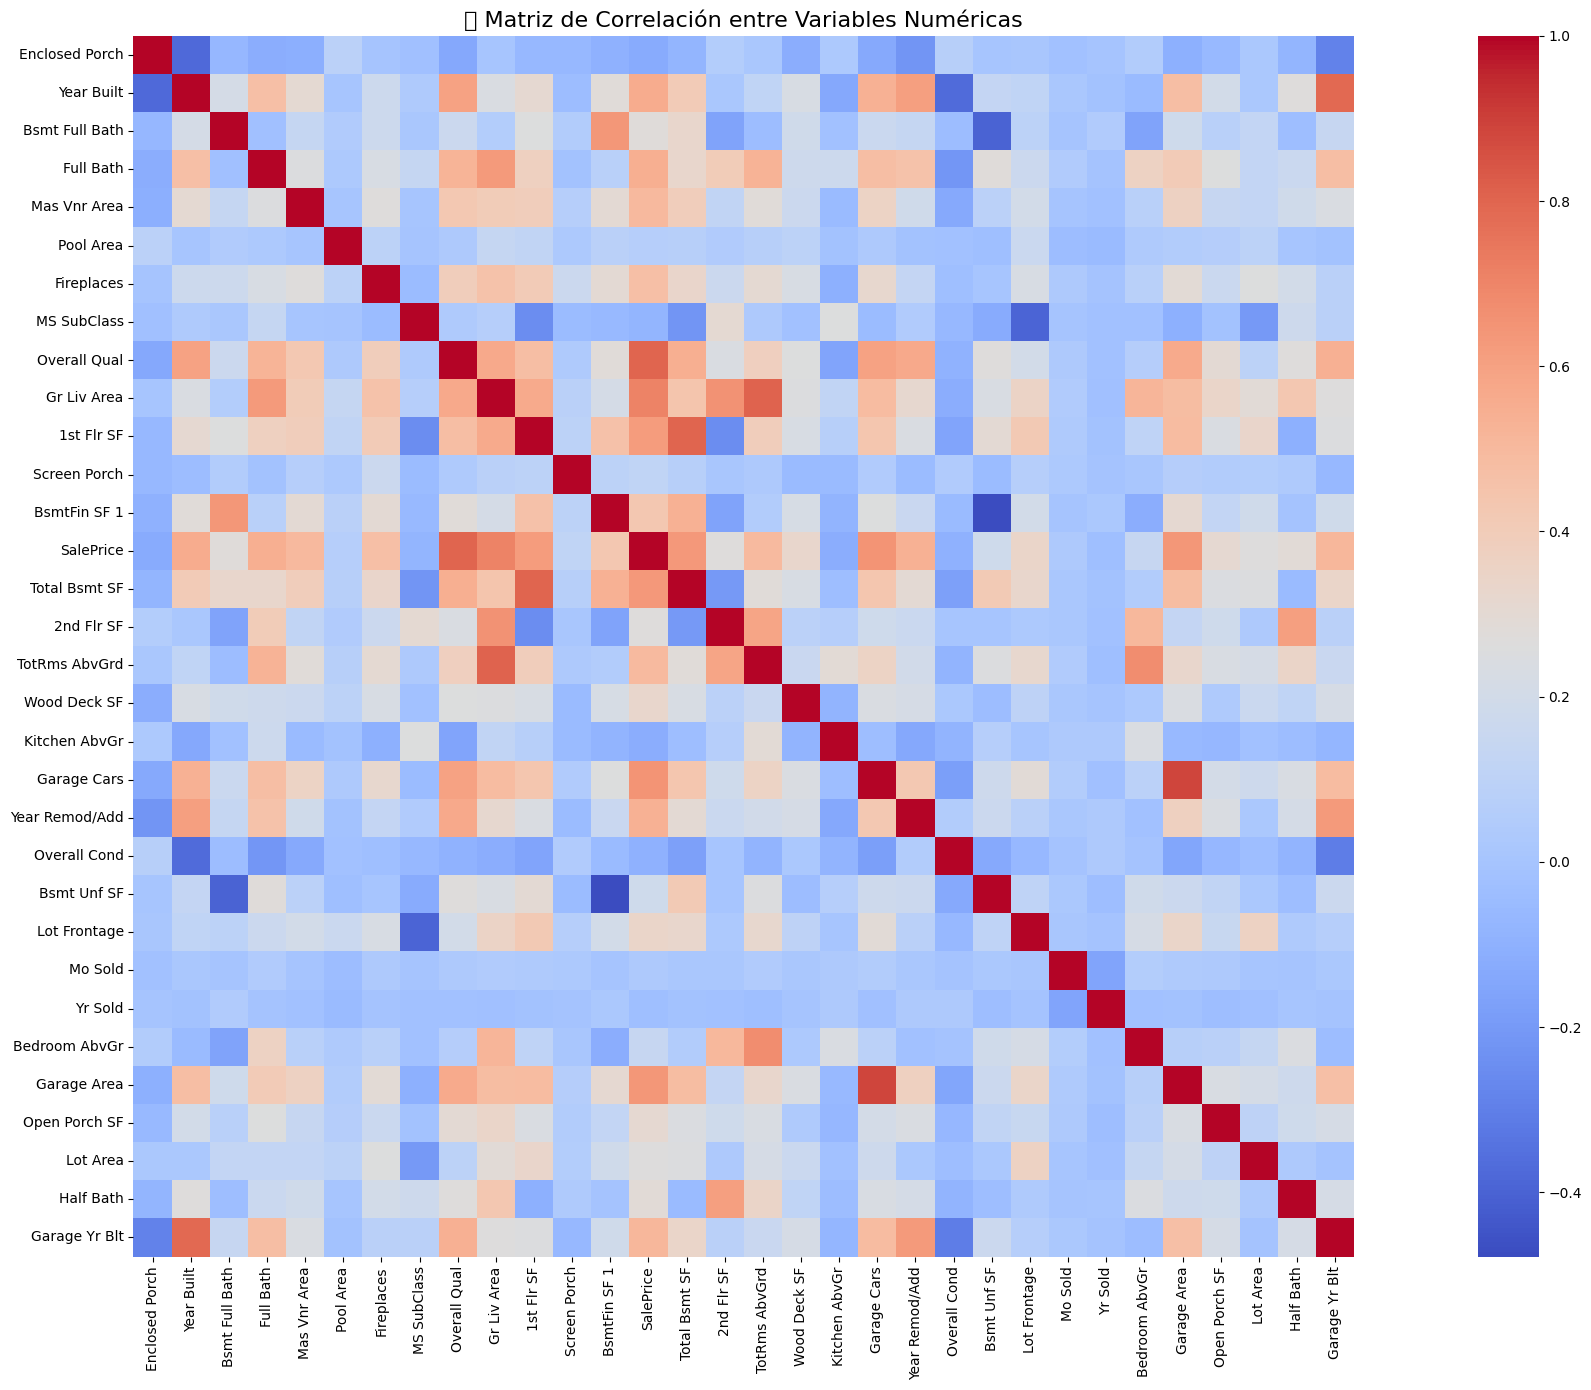

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def mostrar_matriz_correlacion_numerica(df, figsize=(25, 14), cmap='coolwarm', anotar=False):
    """
    Calcula y muestra la matriz de correlación entre variables numéricas de un DataFrame.

    Parámetros:
    - df: DataFrame original
    - figsize: tamaño de la figura (por defecto 20x16)
    - cmap: paleta de colores (por defecto 'coolwarm')
    - anotar: si se deben mostrar los valores de correlación en las celdas
    """
    df_num = df.select_dtypes(include=['number'])

    print(f"📐 Variables numéricas: {df_num.shape[1]}")
    print(f"🧮 Calculando matriz de correlación...")

    corr = df_num.corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr, cmap=cmap, annot=anotar, fmt=".2f", square=True)
    plt.title("🔗 Matriz de Correlación entre Variables Numéricas", fontsize=16)
    plt.tight_layout()
    plt.show()

    return corr  # Opcional: retorna la matriz si la quieres usar después


matriz_corr = mostrar_matriz_correlacion_numerica(df)


## 🔡 Codificación de variables cualitativas (ordinales y nominales)

Esta celda realiza la transformación de variables categóricas a un formato numérico compatible con algoritmos de machine learning, siguiendo estos pasos:

### 🔹 Paso 1: Eliminación de columnas nominales con alta cardinalidad
Se eliminan las 5 variables nominales que presentan el mayor número de categorías distintas, ya que pueden generar una explosión de dimensionalidad al aplicar codificación one-hot.

### 🔹 Paso 2: Codificación de variables ordinales
- Se utilizan mapas de orden predefinidos para 10 variables ordinales comunes en el dataset Ames Housing.
- Se emplea `OrdinalEncoder`, que convierte categorías ordenadas en valores numéricos respetando la jerarquía semántica.

### 🔹 Paso 3: Codificación de variables nominales
- Se aplica `OneHotEncoder` con `drop='first'` para evitar colinealidad.
- La codificación ignora categorías desconocidas durante la predicción (`handle_unknown='ignore'`).

📌 Al finalizar, se retorna un DataFrame completamente numérico, listo para el entrenamiento de modelos. Además, se conserva la integridad de las columnas mediante reconstrucción explícita de los nombres.

✅ Este paso es esencial para asegurar que los modelos de regresión interpreten correctamente la información cualitativa del dataset.


In [22]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


def eliminar_nominales_con_mas_valores(df, columnas_nominales, cantidad=5):
    """
    Elimina las columnas nominales que tienen mayor número de categorías distintas.

    Parámetros:
    - df: DataFrame original
    - columnas_nominales: lista de columnas consideradas nominales
    - cantidad: cuántas columnas eliminar (por defecto 5)

    Retorna:
    - df_filtrado: DataFrame sin las columnas eliminadas
    - columnas_eliminadas: lista de nombres de columnas eliminadas
    """
    # Filtrar solo las columnas que están en el DataFrame
    columnas_presentes = [col for col in columnas_nominales if col in df.columns]

    # Calcular número de categorías distintas
    cardinalidades = df[columnas_presentes].nunique().sort_values(ascending=False)

    # Seleccionar las de mayor cardinalidad
    columnas_a_eliminar = cardinalidades.head(cantidad).index.tolist()

    # Eliminar columnas
    df_filtrado = df.drop(columns=columnas_a_eliminar)

    # Reporte
    print(f"🗑️ Columnas eliminadas por alta cardinalidad (más categorías):")
    for col in columnas_a_eliminar:
        print(f" - {col} ({cardinalidades[col]} categorías)")

    return df_filtrado, columnas_a_eliminar


def codificar_variables(df,columnas_nominales):
    """
    Codifica variables ordinales y nominales, retornando un DataFrame numérico.
    Robusta frente a columnas faltantes o datos dispersos.
    """

    # === 1. Definir columnas originales ===
    columnas_ordinales = [
        'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'Heating QC', 'Kitchen Qual', 'Garage Qual', 'Garage Cond', 'Functional'
    ]


    # === 2. Mapas de orden para ordinales ===
    mapas_orden_original = [
        ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                         # Exter Qual
        ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                         # Exter Cond
        ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                   # Bsmt Qual
        ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                   # Bsmt Cond
        ['NA', 'No', 'Mn', 'Av', 'Gd'],                         # Bsmt Exposure
        ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                         # Heating QC
        ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                         # Kitchen Qual
        ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                   # Garage Qual
        ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                   # Garage Cond
        ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']  # Functional
    ]



    # === 3. Filtrar columnas que existen
    columnas_ordinales_existentes = [col for col in columnas_ordinales if col in df.columns]
    columnas_nominales_existentes = [col for col in columnas_nominales if col in df.columns]

    # === 4. Filtrar mapas de orden para columnas que existen
    mapas_dict = dict(zip(columnas_ordinales, mapas_orden_original))
    mapas_orden = [mapas_dict[col] for col in columnas_ordinales_existentes]
    columnas_ordinales = columnas_ordinales_existentes
    columnas_nominales = columnas_nominales_existentes

    print(f"🔢 Ordinales a codificar: {len(columnas_ordinales)}")
    print(f"🔠 Nominales a codificar: {len(columnas_nominales)}")

    # === 5. Preprocesamiento de ordinales
    df[columnas_ordinales] = df[columnas_ordinales].fillna('NA').astype(str)

    # === 6. Crear ColumnTransformer
    transformers = [('ordinal', OrdinalEncoder(categories=mapas_orden, handle_unknown='use_encoded_value', unknown_value=-1), columnas_ordinales)]
    if columnas_nominales:
        transformers.append(('nominal', OneHotEncoder(handle_unknown='ignore', drop='first'), columnas_nominales))

    preprocesador = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # === 7. Aplicar transformación
    X = preprocesador.fit_transform(df)

    # === 8. Convertir matriz dispersa a densa si es necesario
    if hasattr(X, 'toarray'):
        X = X.toarray()

    # === 9. Reconstrucción de nombres de columnas
    nombres_ordinales = columnas_ordinales
    nombres_nominales = preprocesador.named_transformers_['nominal'].get_feature_names_out(columnas_nominales) if columnas_nominales else []
    columnas_passthrough = [col for col in df.columns if col not in columnas_ordinales + columnas_nominales]
    columnas_finales = nombres_ordinales + list(nombres_nominales) + columnas_passthrough

    # === 10. Validar consistencia
    if X.shape[1] != len(columnas_finales):
        print(f"❌ Mismatch: X.shape = {X.shape[1]}, columnas = {len(columnas_finales)}")
        raise ValueError("Desajuste entre columnas codificadas y nombres reconstruidos.")

    # === 11. Crear DataFrame final
    df_codificado = pd.DataFrame(X, columns=columnas_finales)
    df_codificado = df_codificado.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtype == 'object' else col)

    # === 12. Reporte
    print(f"✅ Codificación completada.")
    print(f"📐 Dimensiones del DataFrame codificado: {df_codificado.shape}")
    print(f"🧮 Columnas creadas por OneHotEncoder: {len(nombres_nominales)}")

    return df_codificado



# Luego codificar:

columnas_nominales = [
    'MS SubClass', 'MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
    'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2',
    'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
    'Foundation', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Central Air', 'Electrical',
    'Garage Type', 'Garage Finish', 'Paved Drive', 'Sale Type', 'Sale Condition'
]

# Paso 1: eliminar las 5 columnas nominales con más categorías
df, columnas_eliminadas = eliminar_nominales_con_mas_valores(df, columnas_nominales, cantidad=5)

# Paso 2: actualizar la lista de columnas nominales
columnas_nominales_actualizadas = [col for col in columnas_nominales if col not in columnas_eliminadas]

# Paso 3: codificar
df = codificar_variables(df, columnas_nominales_actualizadas)



🗑️ Columnas eliminadas por alta cardinalidad (más categorías):
 - Neighborhood (28 categorías)
 - Exterior 2nd (17 categorías)
 - Exterior 1st (16 categorías)
 - MS SubClass (16 categorías)
 - Sale Type (10 categorías)
🔢 Ordinales a codificar: 10
🔠 Nominales a codificar: 23
✅ Codificación completada.
📐 Dimensiones del DataFrame codificado: (2930, 139)
🧮 Columnas creadas por OneHotEncoder: 98


## ⚖️ Normalización de variables numéricas (Min-Max Scaling)

Esta celda implementa un pipeline para **normalizar** las variables numéricas del dataset mediante escalado Min-Max (`[0, 1]`), manteniendo la variable objetivo (`SalePrice`) intacta.

### 🔹 Funciones incluidas:
- `separar_datos`: separa `X` (predictoras) e `y` (objetivo).
- `normalizar_datos`: aplica `MinMaxScaler` a todas las columnas numéricas, excepto aquellas especificadas para excluir.
- `reconstruir_dataframe`: reconstruye el DataFrame original combinando `X` normalizado e `y`.
- `aplicar_normalizacion`: ejecuta todo el pipeline.

📌 La normalización mejora la estabilidad numérica y el desempeño de muchos modelos de regresión al llevar todas las variables al mismo rango de escala.


In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def separar_datos(df, target_col='SalePrice'):
    """
    Separa el DataFrame en variables predictoras y objetivo.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

def normalizar_datos(X, columnas_excluir=[]):
    """
    Aplica Min-Max scaling a todas las columnas numéricas de X,
    excepto las especificadas en columnas_excluir.
    """
    # Seleccionar columnas numéricas
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = [col for col in numeric_cols if col not in columnas_excluir]

    # Aplicar MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = X.copy()
    X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Mensaje informativo
    print("✅ Normalización completada exitosamente.")
    print(f"📊 Total de columnas normalizadas: {len(numeric_cols)}")
    print(f"📋 Columnas normalizadas: {numeric_cols}")



    return X_scaled, scaler, numeric_cols

def reconstruir_dataframe(X_scaled, y):
    """
    Reconstruye el DataFrame final combinando X escalado y la variable objetivo.
    """
    return pd.concat([X_scaled, y], axis=1)

# === Ejecución principal (pipeline de normalización) ===
def aplicar_normalizacion(df, target_col='SalePrice'):
    X, y = separar_datos(df, target_col)
    X_scaled, scaler, columnas_normalizadas = normalizar_datos(X)
    df_final = reconstruir_dataframe(X_scaled, y)
    return df_final, scaler, columnas_normalizadas

# === Uso ===
# df es tu DataFrame original preprocesado
df, scaler_obj, columnas_normalizadas = aplicar_normalizacion(df)


✅ Normalización completada exitosamente.
📊 Total de columnas normalizadas: 138
📋 Columnas normalizadas: ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Heating QC', 'Kitchen Qual', 'Garage Qual', 'Garage Cond', 'Functional', 'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM', 'Street_Pave', 'Lot Shape_IR2', 'Lot Shape_IR3', 'Lot Shape_Reg', 'Land Contour_HLS', 'Land Contour_Low', 'Land Contour_Lvl', 'Utilities_NoSeWa', 'Utilities_NoSewr', 'Lot Config_CulDSac', 'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside', 'Land Slope_Mod', 'Land Slope_Sev', 'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA', 'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn', 'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Feedr', 'Condition 2_Norm', 'Condition 2_PosA', 'Condition 2_PosN', 'Condition 2_RRAe', 'Condition 2_RRAn', 'Condition 2_RRNn', 'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'B

In [24]:
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets




def mostrar_filas_scroll(inicio=0):
    fin = inicio + 20
    subset = df.iloc[inicio:fin]

    html = subset.to_html(max_rows=20)
    scroll_html = f'''
    <div style="overflow-x: auto; white-space: nowrap">
        {html}
    </div>
    '''
    display(HTML(scroll_html))

widgets.interact(mostrar_filas_scroll, inicio=widgets.IntSlider(min=0, max=max(len(df)-20, 1), step=1, value=0))

interactive(children=(IntSlider(value=0, description='inicio', max=2910), Output()), _dom_classes=('widget-int…

<function __main__.mostrar_filas_scroll(inicio=0)>

## ✂️ División del conjunto de datos en entrenamiento y prueba

Esta celda divide el DataFrame final en dos subconjuntos:

- `X_train` / `y_train`: conjunto de entrenamiento (80% por defecto).
- `X_test` / `y_test`: conjunto de prueba (20% por defecto).

Se utiliza la función `train_test_split` de `sklearn.model_selection` con una semilla fija (`random_state=42`) para garantizar reproducibilidad.

📌 Esta división es fundamental para evaluar el desempeño real de los modelos en datos no vistos durante el entrenamiento.


In [25]:
from sklearn.model_selection import train_test_split

def dividir_entrenamiento_test(df, variable_objetivo='SalePrice', test_size=0.2, random_state=42):
    """
    Divide el DataFrame en conjuntos de entrenamiento y prueba.
    - X: variables predictoras
    - y: variable objetivo (por defecto 'SalePrice')

    Retorna: X_train, X_test, y_train, y_test
    """
    if variable_objetivo not in df.columns:
        raise ValueError(f"La variable objetivo '{variable_objetivo}' no se encuentra en el DataFrame.")

    X = df.drop(columns=[variable_objetivo])
    y = df[variable_objetivo]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print(f"📊 División completada:")
    print(f" - Entrenamiento: {X_train.shape[0]} filas")
    print(f" - Prueba:        {X_test.shape[0]} filas")

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = dividir_entrenamiento_test(df)



📊 División completada:
 - Entrenamiento: 2344 filas
 - Prueba:        586 filas


In [14]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


## 🤖 Evaluación comparativa de modelos de regresión con optimización de hiperparámetros

Esta celda implementa un pipeline completo para comparar el rendimiento de varios modelos de regresión utilizando diferentes estrategias de búsqueda de hiperparámetros.

### 🔹 Modelos evaluados:
- `LinearRegression`
- `Lasso`
- `ElasticNet`
- `KernelRidge`
- `SGDRegressor`

### 🔹 Métodos de búsqueda de hiperparámetros:
- `GridSearchCV`: búsqueda exhaustiva sobre una malla de valores.
- `RandomizedSearchCV`: búsqueda aleatoria sobre una distribución.
- `BayesSearchCV`: búsqueda bayesiana basada en procesos gaussianos (usando `skopt`).

### 🔹 Métricas calculadas (con validación cruzada 5-fold):
- MAE (Error absoluto medio)
- MSE (Error cuadrático medio)
- R² (Coeficiente de determinación)
- MAPE (Error porcentual absoluto medio)

📌 El mejor estimador de cada combinación modelo-método se evalúa con `cross_val_score`, y los resultados se formatean como `media ± desviación estándar`.

✅ Esta sección es clave para identificar el modelo con mejor rendimiento predictivo antes de pasar a visualizaciones o ensamblado de modelos.


In [26]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from scipy.stats import uniform

# Validación cruzada y métricas
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

# Crear pipeline
def crear_pipeline(modelo):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', modelo)
    ])

# Evaluación de métricas
def evaluar_modelo_crossval(pipeline, X, y, modelo_nombre, metodo_nombre):
    resultados = {}
    for nombre, scorer in scorers.items():
        scores = cross_val_score(pipeline, X, y, scoring=scorer, cv=cv)
        resultados[nombre] = (scores.mean(), scores.std())
    return {'Modelo': modelo_nombre, 'Método': metodo_nombre, **resultados}

# Buscar hiperparámetros
def buscar_hiperparametros(pipeline, metodo, espacio, X, y):
    if metodo == 'grid':
        buscador = GridSearchCV(pipeline, espacio, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    elif metodo == 'random':
        buscador = RandomizedSearchCV(pipeline, espacio, n_iter=20, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
    elif metodo == 'bayes':
        buscador = BayesSearchCV(pipeline, espacio, n_iter=20, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
    else:
        raise ValueError("Método no reconocido")
    buscador.fit(X, y)
    return buscador.best_estimator_

# Procesamiento final de resultados
def procesar_resultados(df_resultados):
    df_limpio = df_resultados.copy()
    for col in ['MAE', 'MSE', 'R2', 'MAPE']:
        df_limpio[col] = df_limpio[col].apply(lambda x: f"{x[0]:.4f} ± {x[1]:.4f}")
    df_limpio['Modelo-Método'] = df_limpio['Modelo'] + ' - ' + df_limpio['Método']
    return df_limpio.set_index('Modelo-Método')[['MAE', 'MSE', 'R2', 'MAPE']]

# Modelos
modelos = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(max_iter=10000),
    'ElasticNet': ElasticNet(max_iter=10000),
    'KernelRidge': KernelRidge(),
    'SGDRegressor': SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
}

# Espacios de hiperparámetros
espacios = {
    'Lasso': {
        'grid': {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
        'random': {'model__alpha': uniform(0.0001, 10)},
        'bayes': {'model__alpha': Real(0.0001, 10.0, prior='log-uniform')}
    },
    'ElasticNet': {
        'grid': {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'model__l1_ratio': [0.1, 0.5, 0.9]
        },
        'random': {
            'model__alpha': uniform(0.0001, 10),
            'model__l1_ratio': uniform(0.0, 1.0)
        },
        'bayes': {
            'model__alpha': Real(0.0001, 10.0, prior='log-uniform'),
            'model__l1_ratio': Real(0.0, 1.0)
        }
    },
    'KernelRidge': {
        'grid': {
            'model__alpha': [0.01, 0.1, 1.0],
            'model__gamma': [0.001, 0.01, 0.1],
            'model__kernel': ['rbf']
        },
        'random': {
            'model__alpha': uniform(0.01, 1),
            'model__gamma': uniform(0.001, 0.1),
            'model__kernel': ['rbf']
        },
        'bayes': {
            'model__alpha': Real(0.01, 1.0, prior='log-uniform'),
            'model__gamma': Real(0.001, 0.1, prior='log-uniform'),
            'model__kernel': Categorical(['rbf'])
        }
    },
    'SGDRegressor': {
        'grid': {'model__alpha': [0.0001, 0.001, 0.01], 'model__penalty': ['l2', 'l1']},
        'random': {'model__alpha': uniform(0.0001, 0.1), 'model__penalty': ['l2', 'l1', 'elasticnet']},
        'bayes': {'model__alpha': Real(0.0001, 0.1, prior='log-uniform'), 'model__penalty': Categorical(['l2', 'l1', 'elasticnet'])}
    },
    'LinearRegression': {
        'grid': {},
        'random': {},
        'bayes': {}
    }
}

# Evaluación total
resultados_finales = []
for nombre_modelo, modelo in modelos.items():
    for metodo in ['grid', 'random', 'bayes']:
        if espacios[nombre_modelo][metodo] == {}:
            pipe = crear_pipeline(modelo)
            resultado = evaluar_modelo_crossval(pipe, X_train, y_train, nombre_modelo, metodo.capitalize())
        else:
            pipe = crear_pipeline(modelo)
            best_model = buscar_hiperparametros(pipe, metodo, espacios[nombre_modelo][metodo], X_train, y_train)
            resultado = evaluar_modelo_crossval(best_model, X_train, y_train, nombre_modelo, metodo.capitalize())
        resultados_finales.append(resultado)

# Mostrar resultados
df_resultados_modelos = pd.DataFrame(resultados_finales)
df_resultados_procesados = procesar_resultados(df_resultados_modelos)
display(df_resultados_procesados)


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.08213972916549481]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.3586900184022506]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.0029908287628516612]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.001331473198090532]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.0001077137981970081]
  w

,MAE,MSE,R2,MAPE
Modelo-Método,,,,
LinearRegression - Grid,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
LinearRegression - Random,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
LinearRegression - Bayes,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
Lasso - Grid,19104.6384 ± 1543.0119,1351204012.6504 ± 761557762.9155,0.7743 ± 0.1254,0.1166 ± 0.0096
Lasso - Random,19105.6849 ± 1542.8241,1351634080.3302 ± 761699681.9222,0.7742 ± 0.1254,0.1166 ± 0.0096
Lasso - Bayes,19104.6384 ± 1543.0119,1351204012.6504 ± 761557762.9155,0.7743 ± 0.1254,0.1166 ± 0.0096
ElasticNet - Grid,18862.5133 ± 1262.1382,1075825605.2931 ± 657225545.5977,0.8202 ± 0.1075,0.1130 ± 0.0088
ElasticNet - Random,18769.8791 ± 1226.3284,1060068090.0522 ± 610108456.3714,0.8228 ± 0.0996,0.1117 ± 0.0091
ElasticNet - Bayes,18764.8851 ± 1212.3735,1055440914.3035 ± 590679586.1563,0.8236 ± 0.0963,0.1114 ± 0.0093


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import randint, uniform
from skopt.space import Real, Categorical, Integer

# Modelos a evaluar
modelos_rf_svr = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Espacios corregidos de hiperparámetros
espacios_rf_svr = {
    'RandomForest': {
        'grid': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 10, None]
        },
        'random': {
            'model__n_estimators': randint(50, 150),        # <- randint de scipy.stats
            'model__max_depth': randint(3, 20)
        },
        'bayes': {
            'model__n_estimators': Integer(50, 150),
            'model__max_depth': Integer(3, 20)
        }
    },
    'SVR': {
        'grid': {
            'model__C': [0.1, 1, 10],
            'model__epsilon': [0.01, 0.1, 0.5],
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['rbf']
        },
        'random': {
            'model__C': uniform(0.1, 10),
            'model__epsilon': uniform(0.01, 0.5),
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['rbf']
        },
        'bayes': {
            'model__C': Real(0.1, 10.0, prior='log-uniform'),
            'model__epsilon': Real(0.01, 0.5),
            'model__gamma': Categorical(['scale', 'auto']),
            'model__kernel': Categorical(['rbf'])
        }
    }
}

# Evaluación y recolección de resultados
resultados_rf_svr = []
for nombre_modelo, modelo in modelos_rf_svr.items():
    for metodo in ['grid', 'random', 'bayes']:
        print(f"▶ Evaluando {nombre_modelo} con {metodo} search...")
        pipe = crear_pipeline(modelo)
        espacio = espacios_rf_svr[nombre_modelo][metodo]
        if espacio == {}:
            best_model = pipe.fit(X_train, y_train)
        else:
            best_model = buscar_hiperparametros(pipe, metodo, espacio, X_train, y_train)
        resultado = evaluar_modelo_crossval(best_model, X_train, y_train, nombre_modelo, metodo.capitalize())
        resultados_rf_svr.append(resultado)

# Mostrar resultados
df_resultados_rf_svr = pd.DataFrame(resultados_rf_svr)
df_resultados_rf_svr_proc = procesar_resultados(df_resultados_rf_svr)
display(df_resultados_rf_svr_proc)


▶ Evaluando RandomForest con grid search...
▶ Evaluando RandomForest con random search...
▶ Evaluando RandomForest con bayes search...


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(9), np.int64(72)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(8), np.int64(78)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(3), np.int64(55)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(16), np.int64(123)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: 

▶ Evaluando SVR con grid search...
▶ Evaluando SVR con random search...
▶ Evaluando SVR con bayes search...


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.5, np.str_('auto'), np.str_('rbf')] before, using random point [7.131114275969269, 0.30768543030425943, 'scale', 'rbf']
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, np.str_('auto'), np.str_('rbf')] before, using random point [0.6447606416483206, 0.3607791030374851, 'auto', 'rbf']
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, np.str_('auto'), np.str_('rbf')] before, using random point [2.503355940667593, 0.07289935121514614, 'scale', 'rbf']
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, np.str_('auto'), np.str_('rbf')]

,MAE,MSE,R2,MAPE
Modelo-Método,,,,
RandomForest - Grid,16239.4163 ± 1538.2916,759088259.8486 ± 379489573.9048,0.8724 ± 0.0627,0.1012 ± 0.0132
RandomForest - Random,16191.4880 ± 1455.4269,749681488.2894 ± 347022296.0396,0.8739 ± 0.0576,0.1008 ± 0.0127
RandomForest - Bayes,16136.1770 ± 1404.0260,743631133.5760 ± 336421940.9685,0.8749 ± 0.0560,0.1004 ± 0.0123
SVR - Grid,53624.4729 ± 2373.9778,6223188945.5191 ± 494222611.6812,-0.0471 ± 0.0156,0.3150 ± 0.0171
SVR - Random,53628.5598 ± 2373.9182,6223959491.2286 ± 494195992.3863,-0.0473 ± 0.0156,0.3150 ± 0.0171
SVR - Bayes,53624.4729 ± 2373.9778,6223188945.5191 ± 494222611.6812,-0.0471 ± 0.0156,0.3150 ± 0.0171


In [56]:
# 1. Unir resultados en bruto
df_resultados_todos = pd.concat([df_resultados_modelos, df_resultados_rf_svr], ignore_index=True)

# 2. Procesar todos los resultados (formatear ± std, etc.)
df_resultados_todos_proc = procesar_resultados(df_resultados_todos)

# 3. Mostrar la tabla completa
display(df_resultados_todos_proc)


,MAE,MSE,R2,MAPE
Modelo-Método,,,,
LinearRegression - Grid,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
LinearRegression - Random,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
LinearRegression - Bayes,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
Lasso - Grid,19104.6384 ± 1543.0119,1351204012.6504 ± 761557762.9155,0.7743 ± 0.1254,0.1166 ± 0.0096
Lasso - Random,19105.6849 ± 1542.8241,1351634080.3302 ± 761699681.9222,0.7742 ± 0.1254,0.1166 ± 0.0096
Lasso - Bayes,19104.6384 ± 1543.0119,1351204012.6504 ± 761557762.9155,0.7743 ± 0.1254,0.1166 ± 0.0096
ElasticNet - Grid,18862.5133 ± 1262.1382,1075825605.2931 ± 657225545.5977,0.8202 ± 0.1075,0.1130 ± 0.0088
ElasticNet - Random,18769.8791 ± 1226.3284,1060068090.0522 ± 610108456.3714,0.8228 ± 0.0996,0.1117 ± 0.0091
ElasticNet - Bayes,18764.8851 ± 1212.3735,1055440914.3035 ± 590679586.1563,0.8236 ± 0.0963,0.1114 ± 0.0093


In [68]:
# Paso 1: Combinar ambos resultados crudos
df_resultados_completo = pd.concat([df_resultados_modelos, df_resultados_rf_svr], ignore_index=True)

# Paso 2: Crear una columna auxiliar solo con el valor de MAE (sin desviación estándar)
df_resultados_completo['MAE_valor'] = df_resultados_completo['MAE'].apply(lambda x: x[0])

# Paso 3: Seleccionar la mejor fila por modelo (el que tenga menor MAE)
df_mejores_modelos = df_resultados_completo.loc[
    df_resultados_completo.groupby('Modelo')['MAE_valor'].idxmin()
].reset_index(drop=True)

# Paso 4: Procesar para mostrar en formato bonito (± std y nombre combinado)
df_mejores_modelos_proc = procesar_resultados(df_mejores_modelos)

# Paso 5: Mostrar tabla final
display(df_mejores_modelos_proc)


,MAE,MSE,R2,MAPE
Modelo-Método,,,,
ElasticNet - Bayes,18764.8851 ± 1212.3735,1055440914.3035 ± 590679586.1563,0.8236 ± 0.0963,0.1114 ± 0.0093
KernelRidge - Bayes,15437.4639 ± 1643.6850,868917214.8637 ± 617012283.9631,0.8543 ± 0.1020,0.0923 ± 0.0118
Lasso - Grid,19104.6384 ± 1543.0119,1351204012.6504 ± 761557762.9155,0.7743 ± 0.1254,0.1166 ± 0.0096
LinearRegression - Grid,19157.4174 ± 1557.6074,1368926206.0328 ± 771048263.7705,0.7714 ± 0.1270,0.1173 ± 0.0102
RandomForest - Bayes,16136.1770 ± 1404.0260,743631133.5760 ± 336421940.9685,0.8749 ± 0.0560,0.1004 ± 0.0123
SGDRegressor - Bayes,22915.0118 ± 2553.3837,1935368621.1586 ± 1472766684.9211,0.6766 ± 0.2425,0.1629 ± 0.0579
SVR - Grid,53624.4729 ± 2373.9778,6223188945.5191 ± 494222611.6812,-0.0471 ± 0.0156,0.3150 ± 0.0171


<Figure size 1000x500 with 0 Axes>

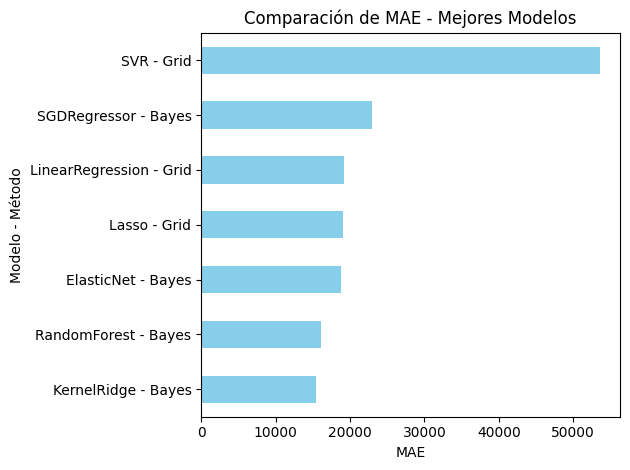

In [69]:
import matplotlib.pyplot as plt

# Extraer valores numéricos de las métricas
df_plot = df_mejores_modelos.copy()
df_plot['Modelo-Método'] = df_plot['Modelo'] + ' - ' + df_plot['Método']
df_plot['MAE'] = df_plot['MAE'].apply(lambda x: x[0])
df_plot['MSE'] = df_plot['MSE'].apply(lambda x: x[0])
df_plot['R2'] = df_plot['R2'].apply(lambda x: x[0])
df_plot['MAPE'] = df_plot['MAPE'].apply(lambda x: x[0])

# Barplot MAE
plt.figure(figsize=(10, 5))
df_plot.sort_values(by='MAE', ascending=True).plot(
    x='Modelo-Método', y='MAE', kind='barh', legend=False, color='skyblue')
plt.title('Comparación de MAE - Mejores Modelos')
plt.xlabel('MAE')
plt.ylabel('Modelo - Método')
plt.tight_layout()
plt.show()


In [76]:
# Paso 1: Combinar todos los resultados (si aún no lo hiciste)
df_resultados_completo = pd.concat([df_resultados_modelos, df_resultados_rf_svr], ignore_index=True)

# Paso 2: Calcular la columna auxiliar con el valor medio del MAE
df_resultados_completo['MAE_valor'] = df_resultados_completo['MAE'].apply(lambda x: x[0])

# Paso 3: Tomar directamente los 3 mejores modelos globales (según MAE más bajo)
top3_modelos = df_resultados_completo.nsmallest(3, 'MAE_valor')

# Paso 4: Procesar para mostrar bonito (± std y nombre combinado)
top3_proc = procesar_resultados(top3_modelos)

# Paso 5: Mostrar la tabla
display(top3_proc)


,MAE,MSE,R2,MAPE
Modelo-Método,,,,
KernelRidge - Bayes,15437.4639 ± 1643.6850,868917214.8637 ± 617012283.9631,0.8543 ± 0.1020,0.0923 ± 0.0118
KernelRidge - Grid,15607.0194 ± 1714.5557,916134576.3429 ± 715958536.5075,0.8464 ± 0.1183,0.0944 ± 0.0119
RandomForest - Bayes,16136.1770 ± 1404.0260,743631133.5760 ± 336421940.9685,0.8749 ± 0.0560,0.1004 ± 0.0123


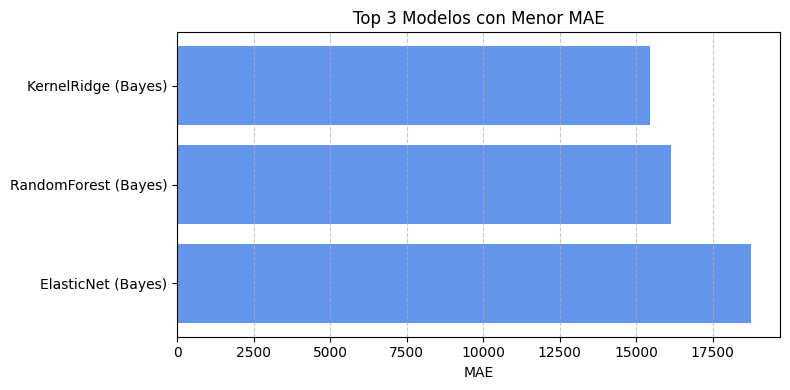

In [63]:
import matplotlib.pyplot as plt

# Asegúrate de tener la columna 'MAE_valor' en df_mejores_modelos
# Si no la tienes, crea esta columna de nuevo
df_mejores_modelos['MAE_valor'] = df_mejores_modelos['MAE'].apply(lambda x: x[0])

# Seleccionar los 3 mejores modelos (menor MAE)
top3 = df_mejores_modelos.nsmallest(3, 'MAE_valor').copy()
top3['Modelo-Método'] = top3['Modelo'] + ' (' + top3['Método'] + ')'

# Graficar
plt.figure(figsize=(8, 4))
plt.barh(top3['Modelo-Método'], top3['MAE_valor'], color='cornflowerblue')
plt.xlabel('MAE')
plt.title('Top 3 Modelos con Menor MAE')
plt.gca().invert_yaxis()  # El mejor arriba
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(9), np.int64(72)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(8), np.int64(78)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(3), np.int64(55)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(16), np.int64(150)] before, using random point [np.int64(16), np.int64(123)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: 

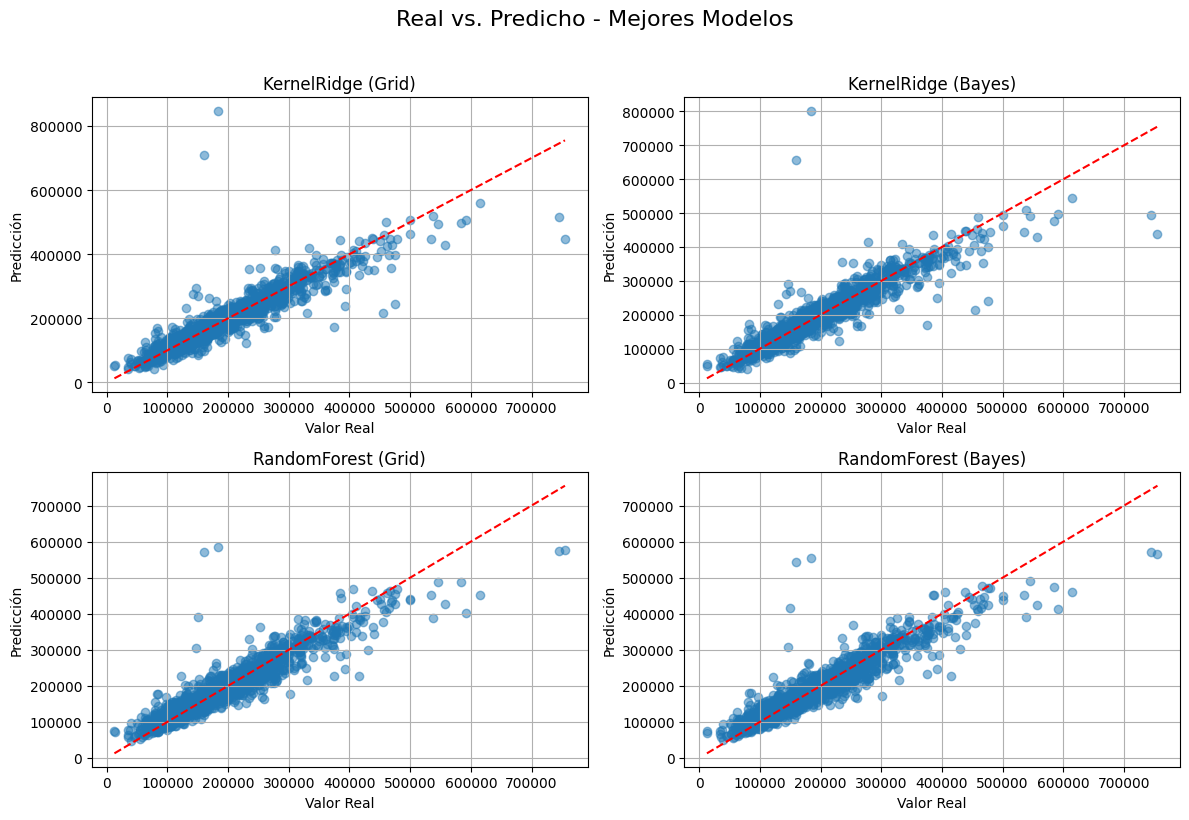

In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

# Filtra solo los modelos que quieres graficar (top 3 ya los tienes)
modelos_top = df_resultados_completo.loc[
    df_resultados_completo['Modelo'].isin(['KernelRidge', 'RandomForest']) &
    df_resultados_completo['Método'].isin(['Bayes', 'Grid'])
]

# Subplots
n = len(modelos_top)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

# Entrenar y graficar
for i, fila in enumerate(modelos_top.itertuples()):
    modelo_nombre = fila.Modelo
    metodo = fila.Método.lower()

    # Obtener modelo base y espacio
    if modelo_nombre in modelos:
        base_model = modelos[modelo_nombre]
        espacio = espacios[modelo_nombre][metodo]
    else:
        base_model = modelos_rf_svr[modelo_nombre]
        espacio = espacios_rf_svr[modelo_nombre][metodo]

    # Pipeline y ajuste
    pipe = crear_pipeline(base_model)
    if espacio == {}:
        modelo_final = pipe.fit(X_train, y_train)
    else:
        modelo_final = buscar_hiperparametros(pipe, metodo, espacio, X_train, y_train)

    # cross_val_predict sobre entrenamiento
    y_pred = cross_val_predict(modelo_final, X_train, y_train, cv=cv, n_jobs=-1)

    # Plot
    ax = axes[i]
    ax.scatter(y_train, y_pred, alpha=0.5)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    ax.set_title(f'{modelo_nombre} ({fila.Método})')
    ax.set_xlabel('Valor Real')
    ax.set_ylabel('Predicción')
    ax.grid(True)

# Quitar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Real vs. Predicho - Mejores Modelos', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
